1. Select the residue
    - Assingment of HCBCANH file needed
    as well as the full protein assignment
2. Find this residue in hCBCANH
3. Create the grid
    3.1 display the result to check if the reading, threshold is correct, resolution is sufficient
4. Write TALOS files

# 0. Preparation
Import libraries, defining functions, reading the files

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.ndimage import map_coordinates, center_of_mass 
from matplotlib.patches import Circle, PathPatch, Ellipse
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import matplotlib.transforms as transforms
import matplotlib as mpl
import nmrglue as nmr
import seaborn as sns
import os, glob

from homemade import talos_vis as tl
np.set_printoptions(precision=3)

In [2]:
print('numpy\tv.', np.__version__)
print('nmrglue\tv.', nmr.__version__)
print('pandas\tv.', pd.__version__)
print('seaborn\tv.', sns.__version__)
print('matplotlib\tv.', mpl.__version__)

numpy	v. 1.21.5
nmrglue	v. 0.8
pandas	v. 1.3.5
seaborn	v. 0.11.2
matplotlib	v. 3.5.1


## Functions

In [3]:
def shift(n, atom):
    return assignments.reset_index().set_index(['Num', 'Atom']).loc[num, atom]['Shift']

#A function to query a pandas.DataFrame
def query(df, columnname, value):
    return df.where(df[columnname]==value).dropna()

def cs_stat(residue, atom, sstr):
    query_res = f'Res == "{residue}"'
    query_atom = f'Atom == "{atom}"'
    query_2str = f'SndStr == "{sstr}"'
    return PACSY_PLUQ_stats.query(query_res).query(query_atom).query(query_2str)

def transform(distrA, limitsA, limitsB):
    '''Transforms distribution of unevenly distributed points in a space A to space B"
    Input:
    distrA - numpy 2D array [[arrdim1 ...], [arrdim2 ...], [arrdim3 ...], [arrdim4 ...]] - distribution to be transformed.
    limitsA and limitsB (list of tuples) - limits of space A and B, correspondingly, in the form (left, right) - mind the order!
        
    Output:
    distrB - transformed distribution'''
    
    shape=distrA.shape
    distrB = np.empty(shape=distrA.shape)
    for i in range(shape[0]):
        spanA = limitsA[i][1] - limitsA[i][0]
        spanB = limitsB[i][1] - limitsB[i][0]
        for j in range(shape[1]):  
            distrB[i, j] = spanB * (distrA[i, j]-limitsA[i][0]) / spanA + limitsB[i][0]
        
        ### Debug:
       # print(f"spanA = {spanA}\nspanB = {spanB}\nWmin = {limitsA[i][0]}, W'min = {limitsB[i][0]}")
       # print(f"first j = 0, Aj = {distrA[i, 0]}, Bj' = {distrB[i, 0]}")
       # print(f"last j = {j}, Aj = {distrA[i, j]}, Bj' = {distrB[i, j]}")
    return distrB

def dev_from_random_coil(residue, atom, shift): #### not used
    '''Calculates the fractional difference of current chemical shift of an atom of a given type from its tabular random coil chem. shift. 
    Random coil values are taken from TALOS-N table; "ideal" chemical shifts for helix and sheet are taken from PIQCed PACSY database 
    
    Fritzsching, K.J., Hong, M. & Schmidt-Rohr, K. 
    Conformationally selective multidimensional chemical shift ranges in proteins from a PACSY database 
    purged using intrinsic quality criteria. 
    JBiomol NMR 64, 115–130 (2016). 
    https://doi.org/10.1007/s10858-016-0013-5'''
    #rand_c = random_coil_shift_of_interest(residue, atom)
    rand_c = cs_stat(residue, atom, 'C').Mode.values[0]
    pure_helix = cs_stat(residue, atom, 'H').Mode.values[0]
    pure_sheet = cs_stat(residue, atom, 'E').Mode.values[0]
    
    fraction = (shift - rand_c)/(pure_helix-pure_sheet)
    
    return fraction

def propensity_correction(residue, atom, fraction):
    '''Calculates the chemical shift of a given residue, which has the same 2ry structure propensity as the peak of interest, which is shifted by a "fraction"'''
    pure_H = cs_stat(residue, atom, 'H').Mode.values[0]
    pure_E = cs_stat(residue, atom, 'E').Mode.values[0]
    span = abs(pure_H-pure_E)
    rand_c = cs_stat(residue, atom, 'C').Mode.values[0]
    #rand_coil_shift = random_coil_shift_of_interest(residue, atom)
    #return rand_coil_shift + fraction*span
    return rand_c + fraction*span # Return chemical shift

def scatter(peak_maximum, increment, spread): #spread is to be integer: it is the number of points to cover the peak area; increment determines the resolution
    if type(spread) is not int:
        print ("Number of points must be integer")
    points = [peak_maximum]

    for i in range(1, spread+1):
        points.append(round((peak_maximum + increment * i), 2)) # Here: 2 is for rounding up/down. Has nothing to do with number of points, dimensionality, etc!
    for i in range(1, spread+1):
        points.append(round((peak_maximum - increment * i), 2)) # Here: 2 is for rounding up/down. Has nothing to do with number of points, dimensionality, etc!
    points.sort()
    return (points)

In [4]:
def run_id(abs_path):
    run_id = abs_path.split(sep='_')[-1].split(sep='//')[0].split(sep='.')[0]
    return run_id

## Files

***Type the correct paths:***

In [5]:
homedir = os.path.expanduser('~')

# Spectrum

dic_4D, the_4D = nmr.sparky.read("D:/Data/Hydrophobin/hCBCANH4d.ucsf")
###dic_4D, the_4D = nmr.sparky.read("D:\PhD\Hydrophobin4Ds_Katja_12052020\spectra2\hCBCANH\hCBCANH4d.ucsf")
the4D_shape = the_4D.shape

# Assignments

assignments = pd.read_csv(f'{homedir}/sciebo/Hydrophobin_4D_Assignments.tab', header=None, index_col=0, names=['Num', 'Res', 'Atom', 'Shift'], delim_whitespace=True)
#assignments = pd.read_csv('D:\PhD\Hydrophobin_4D_Assignments.tab', header=None, index_col=0, names=['Num', 'Res', 'Atom', 'Shift'], delim_whitespace=True)
sequence = 'SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA'

**Reading table from** *Conformationally Selective Multidimensional Chemical Shift Ranges in Proteins from a PACSY Database Purged Using Intrinsic Quality Criteria* , SI Keith J. Fritzsching , Mei Hong and Klaus Schmidt-Rohr

***Type the correct path:***

In [6]:
pacsy_path = f'{homedir}/Documents/PACSY/pacsy_csv/zavot/data/whlee/pacsy/CSV_032822/'
#pacsy_path = 'C:/Users/Krairy/Documents/PhD/Data Analysis/pacsy_csv/zavot/data/whlee/pacsy/CSV_122820/'

header='Res Atom SndStr Mode Avg Min Max'.split()

PACSY_PLUQ_stats = pd.read_csv(os.path.join(pacsy_path, 'CS_STATS_DB.txt'),
                     names = header, index_col = False)
PACSY_PLUQ_stats.sort_values('Atom', inplace = True)

### To display 10 top rows:
# PACSY_PLUQ_stats.head(10)

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


### Define the min and max ppm at spectrum borders 

In [7]:
## Here:

f4_ppm_lims = (10.595, 5.536) 
f1_ppm_lims = (85.22, 6.39)
f3_ppm_lims = (71.99, 19.44)
f2_ppm_lims = (135.72, 100.13)

f4_axis = 'HN'
f3_axis = 'CA' 
f2_axis = 'N'
f1_axis = 'CB'

In [8]:
limits_ppm = {f4_axis: f4_ppm_lims, 
             f3_axis: f3_ppm_lims,
             f2_axis: f2_ppm_lims,
             f1_axis: f1_ppm_lims}
limits_points = [(0,x) for x in the4D_shape]

#### Visual check: spectrum

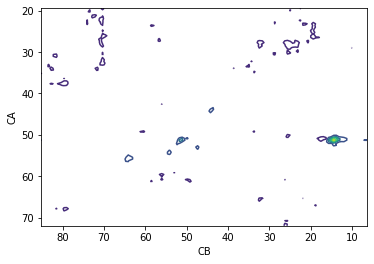

In [9]:
plt.contour(the_4D[105, :, 67, :], extent=(f1_ppm_lims[0], f1_ppm_lims[1], f3_ppm_lims[0], f3_ppm_lims[1]))
#35 - 79 - 43 - 56
plt.gca().set_aspect(1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(f1_axis)
plt.ylabel(f3_axis)
plt.show()

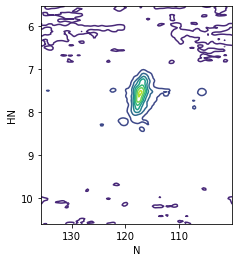

In [10]:
plt.contour(the_4D[:, 51, :, 115], extent=(f2_ppm_lims[0], f2_ppm_lims[1], f4_ppm_lims[0], f4_ppm_lims[1]))
#35 - 79 - 43 - 56
plt.gca().set_aspect(8)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(f2_axis)
plt.ylabel(f4_axis)
plt.show()

# 1. Writing TALOS inputs

***Number of the residue of interest***

In [22]:
num = 55

In [23]:
roi_type = assignments.loc[num]['Res'].unique()[0]
print(f'Residue\t {num}{roi_type}\n\n {assignments.loc[num]}\n\nEligible?\t{("CB" in assignments.loc[num]["Atom"].values) & ("CA" in assignments.loc[num]["Atom"].values)}')

Residue	 55G

     Res Atom    Shift
Num                  
55    G    C  171.800
55    G   CA   43.304
55    G   HN    6.805
55    G    N  110.183

Eligible?	False


In [24]:
assignments.where(assignments.Res == 'G').dropna().index.unique()

Int64Index([25, 30, 34, 37, 41, 55], dtype='int64', name='Num')

## 1.1. Creating the grid for TALOS

In [25]:
### Defining center of the peak by the peak maximum (taking from the assignments)

if roi_type=='G':
    peak_center = np.array([shift(num, f4_axis), shift(num, f3_axis), shift(num, f2_axis), shift(num, f3_axis)]).reshape(4,1)
else:
    peak_center = np.array([shift(num, f4_axis), shift(num, f3_axis), shift(num, f2_axis), shift(num, f1_axis)]).reshape(4,1)

## Or enter the coordinates manually (may be better in the case of skewed peaks)
#peak_center = np.array([8.655, 52.694, 123.86, 17.613]).reshape(4,1)

peak_cent=transform(peak_center, list(limits_ppm.values()), limits_points) # double-check with CCPN v.2.** if the points coordinates are correct
peakmax=map_coordinates(the_4D, peak_cent, order=1)

In [26]:
import time
start=time.time()

f4_incr = 0.4 #float(input('Set the resolution of the grid in F1 dimension (ppm): ')) #1H
f4_spread = 3 #int(input("Set the number of grid's points around maximum in F1 dimension: "))

f3_incr = 0.4 #float(input('Set the resolution of the grid in F3 dimension (ppm): ')) #13Ca
f3_spread = 3 #int(input("Set the number of grid's points around maximum in F3 dimension: "))

f2_incr = 0.75 #float(input('Set the resolution of the grid in F2 dimension (ppm): ')) #15N
f2_spread = 3 #int(input("Set the number of grid's points around maximum in F2 dimension: "))

f1_incr = 0.75 #float(input('Set the resolution of the grid in F4 dimension (ppm): ')) #13Cb
f1_spread = 2 #int(input("Set the number of grid's points around maximum in F4 dimension: "))

scattered_f1 = scatter(float(peak_center[3]), f1_incr, f1_spread)
scattered_f2 = scatter(float(peak_center[2]), f2_incr, f2_spread)
scattered_f3 = scatter(float(peak_center[1]), f3_incr, f3_spread)
scattered_f4 = scatter(float(peak_center[0]), f4_incr, f4_spread)

peak_box = pd.DataFrame()
CO_shift = shift(num, 'C')
#peak_box = np.meshgrid(scattered_f1, scattered_f2, scattered_f3, scattered_f4)

for ppm_f4 in scattered_f4:
    for ppm_f3 in scattered_f3:
        for ppm_f2 in scattered_f2:
            for ppm_f1 in scattered_f1:
                
                coord=np.array([ppm_f4, ppm_f3, ppm_f2, ppm_f1])
                coord=coord.reshape(4,1)
                coord_points = transform(coord, list(limits_ppm.values()), limits_points)
                intensity = map_coordinates(the_4D, coord_points, order=1)
                new_line = pd.DataFrame(data=[[ppm_f4, ppm_f3, ppm_f2, ppm_f1, CO_shift, intensity[0]]], columns=['f4_H', 'f3_CA', 'f2_N', 'f1_CB', 'C', 'Intensity'])
                peak_box = peak_box.append(new_line, ignore_index=True)

#Cutting off the points in the noise (Here: that are less than 15% of intensity of the peak maximum)

peak_box = peak_box.where(peak_box['Intensity'] > peakmax[0]*0.15).dropna()
peak_box.reset_index(drop=True, inplace=True)
                
finish = time.time()
print(f'Run took {finish-start} s')
print(f'Number of TALOS inputs {len(peak_box)}')

Run took 1.654618501663208 s
Number of TALOS inputs 66


In [27]:
peak_box.head(10)

,f4_H,f3_CA,f2_N,f1_CB,C,Intensity
0,6.4,42.900,109.430,43.304,171.8,1.873919e+09
1,6.4,42.900,110.183,43.304,171.8,2.177451e+09
2,6.4,43.304,108.680,43.304,171.8,1.807953e+09
3,6.4,43.304,109.430,43.304,171.8,2.854169e+09
4,6.4,43.304,110.183,43.304,171.8,3.598460e+09
5,6.4,43.304,110.183,44.050,171.8,1.527867e+09
6,6.4,43.304,110.930,43.304,171.8,2.625192e+09
7,6.4,43.700,109.430,43.304,171.8,1.914381e+09
8,6.4,43.700,110.183,43.304,171.8,2.562603e+09
9,6.4,43.700,110.183,44.050,171.8,1.989763e+09


In [28]:
id_max = peak_box[peak_box['Intensity']==peak_box['Intensity'].max()].index[0]
id_max

29

__New!__

### Translation into the "clean zone"

In [29]:
#def translate(cshift):
#    delta = peak_max-cs_stat(num, atom, 'E')
#    cshift_new = cshift-delta

peak_box.columns = ['H', 'CA', 'N', 'CB', 'C', 'Intensity']
    
#lambda shift: shift-(peak_maximum.loc[id_max, atom]+cs_stat(num, atom, 'E'))

for col in peak_box[['H', 'CA', 'N', 'C']]:
    peak_box[col] = peak_box[col] - (peak_box.loc[id_max, col]-cs_stat(roi_type, col, 'E').Mode.values[0])
if roi_type != 'G':
    peak_box['CB'] = peak_box['CB'] - (peak_box.loc[id_max, 'CB']-cs_stat(roi_type, 'CB', 'E').Mode.values[0])
else:
    peak_box['CB'] = peak_box['CA']

In [30]:
peak_box.head(10)

,H,CA,N,CB,C,Intensity
0,8.265,44.606,107.467,44.606,171.47,1.873919e+09
1,8.265,44.606,108.220,44.606,171.47,2.177451e+09
2,8.265,45.010,106.717,45.010,171.47,1.807953e+09
3,8.265,45.010,107.467,45.010,171.47,2.854169e+09
4,8.265,45.010,108.220,45.010,171.47,3.598460e+09
5,8.265,45.010,108.220,45.010,171.47,1.527867e+09
6,8.265,45.010,108.967,45.010,171.47,2.625192e+09
7,8.265,45.406,107.467,45.406,171.47,1.914381e+09
8,8.265,45.406,108.220,45.406,171.47,2.562603e+09
9,8.265,45.406,108.220,45.406,171.47,1.989763e+09


In [31]:
peak_box.columns = ["f4", "f3", "f2", "f1", 'C', "Intensity"]
peak_maximum = peak_box[peak_box['Intensity']==peak_box['Intensity'].max()]

In [32]:
peak_box.to_csv(f"C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/PeakShapes_translated/{num}{roi_type}.csv", sep='\t')

#### Visual check: grid

In [33]:
# Set axes and contour levels (for protons need to abjust ppm limits!)

x='CB'
y='CA'
if roi_type == 'G':
    x = 'CA'
    y = 'N'

base_lvl = 0.05
n_lvl = 18
factor = 1.2

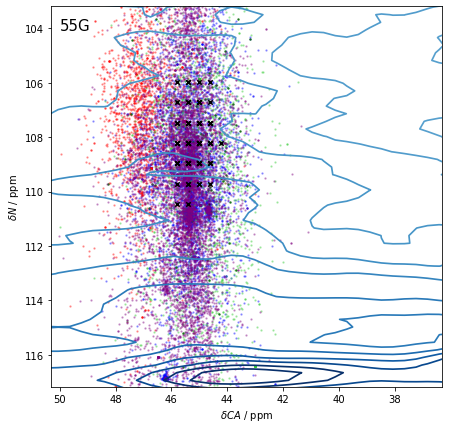

In [47]:
num=55

fig, ax = plt.subplots(1, 1, figsize = (7, 7))

peak_box = pd.read_csv(f"{homedir}/sciebo/Hydrophobin TALOS analysis/PeakShapes_translated/{num}{roi_type}.csv", sep='\t',  index_col=0)
peak_box.columns = ["H", "CA", "N", "CB", "C", "Intensity"]

cl_neg = [-1*base_lvl * factor ** x for x in range(n_lvl)]
cl_neg.reverse()
cl_pos = [base_lvl * factor ** x for x in range(n_lvl)]
cl = cl_neg + cl_pos
norm = mpl.colors.Normalize(vmin=cl[5],vmax=cl[-5])

proj_dims=[0,1,2,3]
proj_dims.remove([f4_axis, f3_axis, f2_axis, f1_axis].index(x))
proj_dims.remove([f4_axis, f3_axis, f2_axis, f1_axis].index(y))

if roi_type=='G':
    #pacsy = pd.read_csv(f'C:/Users/Krairy/sciebo/PACSY_PIQCed/G_HNCACo_PIQCed.csv')
    pacsy = pd.read_csv(f'{homedir}/sciebo/PACSY_PIQCed/G_HNCACo_PIQCed.csv')
    proj = the_4D.sum(axis=tuple(proj_dims))
else:
    #pacsy = pd.read_csv(f'C:/Users/Krairy/sciebo/PACSY_PIQCed/{roi_type}_HNCACB_PIQCed.csv') # reading the arranged table that we generated in GGAGG PACSY analysis.ipynb
    pacsy = pd.read_csv(f'{homedir}/sciebo/PACSY_PIQCed/{roi_type}_HNCACB_PIQCed.csv')
    proj = the_4D.sum(axis=tuple(proj_dims))

proj = proj/proj.max()

ax.contour(proj, np.array(cl),
            extent = (limits_ppm[x][0], limits_ppm[x][1], limits_ppm[y][0], limits_ppm[y][1]), 
            cmap = 'Blues', alpha=1, norm=norm,
            linewidths=1.7, zorder=2)

groups = pacsy.groupby("2strSTRIDE")

#colors=['#3BFFD1', '#5182D2', '#00FF26', '#9900FF', '#FF3B3B', '#8c564b', '#e377c2', '#44ADB3']
colors={"B": "darkgreen",#"yellow", 
        "C": "blue",
        "E": "limegreen",
        "G": "purple",
        #"G": "orange",
        "H": "red",
        #"I": "darkorange",
        "I": "black",
        "b": "mediumseagreen",
        "T": "orchid"}

names = ["C", "H", "E", "B", "T", "G", "I",  "b"]

for name in names:
    #ax.scatter(group['CB'], group['CA'], c=colors[i], marker="o", s=3, label=name, alpha=0.5)
    try:
        group = groups.get_group(name=name)
    except KeyError:
        pass
    if name == "T":
        ax.scatter(group[x], group[y], c=colors["G"], marker="o", s=2, alpha=0.3)
    elif name == "E":
        ax.scatter(group[x], group[y], c=colors["E"], marker="o", s=2, alpha=0.3)
    elif name == "B":
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, label=name, alpha=0.3)
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, alpha=0.3)
        ax.scatter(group[x], group[y], c=colors["B"], marker="o", s=2, alpha=0.3)
    else:
        ax.scatter(group[x], group[y], c=colors[name], marker="o", s=2, label=name, alpha=0.3)
    #peak_regions[name]=group
##########################################################################
#### Plot the points that will be subjected to TALOS ####

ax.scatter(x=peak_box.filter(like=x, axis=1), y=peak_box.filter(like=y, axis=1), c='black', marker='x', s=20, zorder=3)

##########################################################################

ax.set_xlim(peak_center[[f4_axis, f3_axis, f2_axis, f1_axis].index(x),0]+7,peak_center[[f4_axis, f3_axis, f2_axis, f1_axis].index(x),0]-7)
ax.set_ylim(peak_center[[f4_axis, f3_axis, f2_axis, f1_axis].index(y),0]+7,peak_center[[f4_axis, f3_axis, f2_axis, f1_axis].index(y),0]-7)

#ax.set_xlabel('$\delta^{13}C$ / ppm')
#ax.set_ylabel('$\delta^{13}C$ / ppm')
ax.set_xlabel(f'$\delta {x}$ / ppm')
ax.set_ylabel(f'$\delta {y}$ / ppm')

#ax.text(x=27, y=57.8, s='4D limits', transform=    
ax.text(0.1, 0.95, s=f'{num}{roi_type}', va='center', ha='right', fontsize=15,
            transform=ax.transAxes)
#ax.text(x=27, y=58.4, s=f'{limits_ppm}')
fig.savefig(f'{homedir}/sciebo/Hydrophobin TALOS analysis/{num}{roi_type}.png', format='png', dpi=300)
plt.show()

In [215]:
peak_center

array([[  9.003],
       [ 52.161],
       [123.067],
       [ 40.595]])

Is S26 one peak or are these two???
C40 and C46 occur in between oxidized and redused densities - sus!

V44 and K45 are missing CB in hnCACB - non eligible

Why doesn't it overlay with PACSY well?
Referencing?!

In cases like this, the "PACSY method" clearly is not an option!  --- how many points are needed to have "enough" for statistics??

## 1.2 Writing the series of inputs for TALOS for the given residue of interest

In [216]:
### Not really used in the current version

roi_type = assignments.loc[num]['Res'].unique()[0]

fract_dev_from_rand_coil = [dev_from_random_coil(roi_type, atom, shift) 
                                       for atom, shift in zip(['H', 'CA', 'N', 'C'], peak_maximum[['f4', 'f3', 'f2', 'C']].values.ravel())]
dev_from_rand_coil = {key: value for key, value in zip(['H', 'CA', 'N', 'C'], fract_dev_from_rand_coil)}
print('To what fraction of the overall distribution is the maximum of our peak of interest shifted from the random coil?') #### Not used!!
dev_from_rand_coil

To what fraction of the overall distribution is the maximum of our peak of interest shifted from the random coil?


{'H': -0.5999999999999994,
 'CA': -0.2790055248618781,
 'N': -0.5611510791366913,
 'C': -0.22508038585208745}

In [217]:
try:
    os.mkdir(os.path.join(f'{homedir}/sciebo/Hydrophobin TALOS analysis', f'TALOS_inputs_{num}{roi_type}')) # Create the folder with inputs in the current directory
except:
    pass

start=time.time()

template = assignments.copy()

#peak_box.columns = ['w1_H', 'w2_CA', 'w3_N', 'w4_CB', 'Intensity']
peak_box.columns = ['H', 'CA', 'N', 'CB', 'C', 'Intensity']

i = 0

span_residue_of_interest={}

# Calculate the span of chemical shifts (here: difference between chem. shifts of helical and sheet-like structures) 
# for the residue of interest. Chemical shift distributions are taken from PACSY database.
for atom in ["HN", "CA", "N", "CB", 'C']:
    try:
        span_residue_of_interest[atom] = (cs_stat(roi_type, atom, 'H').Mode.values[0] - cs_stat(roi_type, atom, 'E').Mode.values[0]).round(2)
    except IndexError:
        try:
            span_residue_of_interest[atom] = (cs_stat(roi_type, 'H', 'H').Mode.values[0] - cs_stat(roi_type, 'H', 'E').Mode.values[0]).round(2)
        except KeyError:
            print("Something is deeply wrong")

if roi_type == 'G':
    limits_residue_of_interest = [(cs_stat(roi_type, atom, 'H').Mode.values[0], cs_stat(roi_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]
else:    
    limits_residue_of_interest = [(cs_stat(roi_type, atom, 'H').Mode.values[0], cs_stat(roi_type, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'CB', 'C']]

mimic_peak_shapes = {}

for neigh_num in [num-2, num-1, num+1, num+2]: #For each neighbour's number:
    restype = template.loc[neigh_num]['Res'].unique()[0] # get its residue type
    if restype == 'G':
        limits_neighbouring_residue = [(cs_stat(restype, atom, 'H').Mode.values[0], cs_stat(restype, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]
        data = transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
        neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'C'])
    else:
        limits_neighbouring_residue = [(cs_stat(restype, atom, 'H').Mode.values[0], cs_stat(restype, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'CB', 'C']]
        if roi_type == 'G':
            data = transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
            ##################data  ########
            limits_neighbouring_residue = [(cs_stat(restype, atom, 'H').Mode.values[0], cs_stat(restype, atom, 'E').Mode.values[0]) for atom in ['H', 'CA', 'N', 'C']]
            data = transform(peak_box[['H', 'CA', 'N', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
            neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'C'])
            neighbor_box['CB'] = ((neighbor_box['CA'] - cs_stat(restype, 'CA', 'H').Mode.values[0]) * 
                      (cs_stat(restype, 'CB', 'H').Mode.values[0] - cs_stat(restype, 'CB', 'E').Mode.values[0]) / 
                      (cs_stat(restype, 'CA', 'H').Mode.values[0] - cs_stat(restype, 'CA', 'E').Mode.values[0])
                      + cs_stat(restype, 'CB', 'H').Mode.values[0])
        else:
            data = transform(peak_box[['H', 'CA', 'N', 'CB', 'C']].values.T, limits_residue_of_interest, limits_neighbouring_residue).T
            neighbor_box = pd.DataFrame(data, columns=['H', 'CA', 'N', 'CB', 'C'])
    
    mimic_peak_shapes[neigh_num] = neighbor_box

sample_every_Nth_point=1 # SAMPLE EVERY 3rd POINT ??

for i in range(0, len(peak_box), sample_every_Nth_point): 

    subj = template.copy()
    subj.set_index('Atom', append=True, inplace=True)
    
    subj.at[(num, 'HN'), 'Shift'] = peak_box.at[i, 'H'].round(2)
    subj.at[(num, 'CA'), 'Shift'] = peak_box.at[i, 'CA'].round(2)
    subj.at[(num, 'N'), 'Shift'] = peak_box.at[i, 'N'].round(2)
    try: 
        subj.at[(num, 'C'), 'Shift'] = peak_box['C'].round(2)
    except: 
        pass

    if restype != 'G':
        subj.at[(num, 'CB'), 'Shift'] = peak_box.at[i, 'CB'].round(2)

    for neigh_num in [num-2, num-1, num+1, num+2]:
        
        restype = subj.loc[neigh_num]['Res'].unique()[0] # get its residue type

        subj.at[(neigh_num, 'HN'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'H'].round(2)
        subj.at[(neigh_num, 'N'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'N'].round(2)
        subj.at[(neigh_num, 'CA'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'CA'].round(2)
        try: 
            subj.at[(neigh_num, 'C'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'C'].round(2)
        except: 
            pass
        if restype != 'G':
            #subj.at[template.loc[(template[0] == neigh_num) & (template[2] == 'CB')].index[0], 3]  = mimic_peak_shapes[neigh_num].at[i, 'CB'].round(2)
            subj.at[(neigh_num, 'CB'), 'Shift'] = mimic_peak_shapes[neigh_num].at[i, 'CB'].round(2)
    
    fname = os.path.join(f'{homedir}/sciebo/Hydrophobin TALOS analysis', f'TALOS_inputs_{num}{roi_type}', str(i)+'.tab')
    subj.set_index('Res', append=True).reorder_levels(['Num', 'Res', 'Atom']).to_csv(fname, sep = ' ', header=None) 
    with open(fname, 'r') as original: 
        data = original.read()
    with open(fname, 'w') as modified: # ...then write to this file the preamble and everything that was in the file before
        modified.write(f'''REMARK EASd15 {num}{roi_type} series

DATA FIRST_RESID 1

DATA SEQUENCE {sequence}

VARS   RESID RESNAME ATOMNAME SHIFT
FORMAT %4d   %1s     %4s      %8.3f
{data}''')
        
finish = time.time()
print(f'The run took {round(finish-start, 1)} s')
print(str(len(glob.glob(os.path.join(f'{homedir}/sciebo/Hydrophobin TALOS analysis', f'TALOS_inputs_{num}{roi_type}', '*.tab')))) + ' files were written')

The run took 2.7 s
173 files were written


***Now run TALOS with all these files.***

-----------------

# 2. Analysing of TALOS predictions
## 2.1 Reading and visualizing predictions

***Type the correct paths:***

54, 28 - a lot of inputs! Check if the predictions are complete

In [315]:
num = 53 # Number of the residue of interest 

In [319]:
sequence = 'SATTIGPNTCSIDDYKPYCCQSMSGSASLGCVVGVIGSQCGASVKCCKDDVTNTGNSFLIINAANCVA'
absolute_path = 'C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/' 

assignments = pd.read_csv(os.path.join(absolute_path, '../Hydrophobin_4D_Assignments.tab'), header=None, index_col=0, names=['Num', 'Res', 'Atom', 'Shift'], delim_whitespace=True)
roi_type = assignments.loc[num]['Res'].unique()[0]

#peak_box = pd.read_csv(os.path.join(absolute_path, f'PeakShapes_translated/{num}{roi_type}.csv'), sep='\t', index_col=0)
peak_box = pd.read_csv(os.path.join(absolute_path, f'PeakShapes/{num}{roi_type}.csv'), sep='\t', index_col=0)

In [320]:
paths = os.path.join(absolute_path, 'Results forced', f'{num}{roi_type}/*/predABP.tab')
#paths = os.path.join(absolute_path, 'Results natural', f'{num}{roi_type}/*/predABP.tab')
number_of_TALOS_outputs = len(glob.glob(paths))
number_of_TALOS_outputs

52

In [321]:
print('Predictions complete:', number_of_TALOS_outputs == len(peak_box))
print('Prediction missing for ' + str(len(peak_box) - number_of_TALOS_outputs) + ' points')

Predictions complete: False
Prediction missing for 121 points


### 2.1.1 Looking at particular points
#### We want to look at Ramachandran maps of a. the peak maximum; b. most "helical" propencity; c. the most "sheet-like" one

#### 1. Peak maximum

In [252]:
idM = peak_box.Intensity.idxmax()

print('Peak maximum is the point #', idM)

Peak maximum is the point # 29


In [253]:
peak_box.loc[peak_box.Intensity.idxmax()]

f4           6.805000e+00
f3           4.330400e+01
f2           1.101830e+02
f1           4.330400e+01
C            1.718000e+02
Intensity    1.005848e+10
Name: 29, dtype: float64

In [254]:
peak_box.columns = ['f4', 'f3', 'f2', 'f1', 'C', 'Intensity']

In [255]:
print('Peak borders:\n'
f'\t{f3_axis}\t' , peak_box['f3'].min(), peak_box['f3'].max(), '  (f3) \n',
f'\t{f1_axis}\t', peak_box['f1'].min(), peak_box['f1'].max(), '  (f1) \n',
f'\t{f2_axis}\t', peak_box['f2'].min(), peak_box['f2'].max(), '(f2) \n',
f'\t{f4_axis}\t', peak_box['f4'].min(), peak_box['f4'].max(), '   (f4)'     )

Peak borders:
	CA	 42.5 44.1   (f3) 
 	CB	 42.55 44.05   (f1) 
 	N	 107.93 112.43 (f2) 
 	HN	 6.4 8.0    (f4)


#### 2. "Helical" point: 13Cb MINIMUM -> 13Ca MAXIMUM possible -> 15N MIN possible

In [256]:
first_selection = peak_box.where(peak_box['f1'] == peak_box['f1'].min()).dropna()
second_selection = first_selection.where(first_selection['f3'] == first_selection['f3'].max()).dropna()
third_selection = second_selection.where(second_selection['f2'] == second_selection['f2'].min()).dropna()
helical_point = third_selection.where(third_selection['f4'] == third_selection['f4'].min()).dropna()
idH = helical_point.index[0]
helical_point

,f4,f3,f2,f1,C,Intensity
25,6.805,43.304,109.43,42.55,171.8,2.130918e+09


#### 3. "Sheety" point: 13Cb MAXIMUM -> 13Ca MINIMUM possible -> 15N MAX possible

In [257]:
first_selection = peak_box.where(peak_box['f1'] == peak_box['f1'].max()).dropna()
second_selection = first_selection.where(first_selection['f3'] == first_selection['f3'].min()).dropna()
third_selection = second_selection.where(second_selection['f2'] == second_selection['f2'].max()).dropna()
sheety_point = third_selection.where(third_selection['f4'] == third_selection['f4'].max()).dropna()
idE = sheety_point.index[0]
#sheety_points = peak_of_interest.where(peak_of_interest['f1'] == peak_of_interest['f1'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()
sheety_point

,f4,f3,f2,f1,C,Intensity
35,6.805,43.304,111.68,44.05,171.8,2.055047e+09


Or select points manually:

In [258]:
"""first_selection = peak_of_interest.where(peak_of_interest['w4'] == 23.610).dropna()
second_selection = first_selection.where(first_selection['w2'] == 51.690).dropna()
sheety_point_old = second_selection.where(second_selection['w3'] == 123.86).dropna()
sheety_point_old = sheety_point_old.where(sheety_point_old['w1'] == 9.460).dropna()

#sheety_points = peak_of_interest.where(peak_of_interest['w4'] == peak_of_interest['w4'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()
sheety_point_old"""

"first_selection = peak_of_interest.where(peak_of_interest['w4'] == 23.610).dropna()\nsecond_selection = first_selection.where(first_selection['w2'] == 51.690).dropna()\nsheety_point_old = second_selection.where(second_selection['w3'] == 123.86).dropna()\nsheety_point_old = sheety_point_old.where(sheety_point_old['w1'] == 9.460).dropna()\n\n#sheety_points = peak_of_interest.where(peak_of_interest['w4'] == peak_of_interest['w4'].max()-0.4).dropna().where(peak_of_interest['w2'] < peak_of_interest['w2'].min()+0.8).dropna()\nsheety_point_old"

### max, H and E:

In [259]:
peak_box.loc[[idM, idH, idE]]

,f4,f3,f2,f1,C,Intensity
29,6.805,43.304,110.183,43.304,171.8,1.005848e+10
25,6.805,43.304,109.430,42.550,171.8,2.130918e+09
35,6.805,43.304,111.680,44.050,171.8,2.055047e+09


## Now plot the selected points:

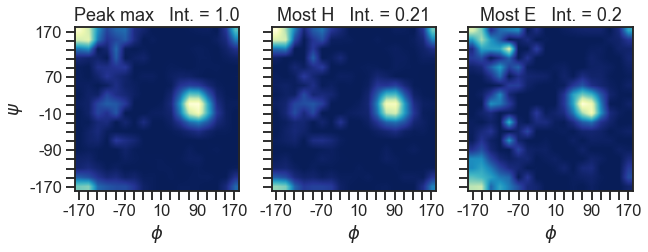

In [260]:
sns.set_context("talk")
sns.set_style("ticks")

queries = [idM, idH, idE]
list_of_experiments = []

# first point: closest to absolute maximum; 2nd: 'helical', 3rd: 'sheet'

list_of_all_experiments = glob.glob(paths)
#list_of_experiments = random.choices(list_of_all_experiments, k=10)
for i in queries:
    list_of_experiments.append(list_of_all_experiments[0].replace('pred_0', f'pred_{str(i)}'))

seq_lbls = [f'{num} {roi_type}']
dic_plotgrid_full = tl.get_working_dic(list_of_experiments[0])
dic_plotgrid = {res: dic_plotgrid_full[res] for res in seq_lbls}

fig, axs = plt.subplots(len(dic_plotgrid), len(list_of_experiments), figsize=(10,10))
#fig, axs = plt.subplots(1, 1, figsize=((len(list_of_experiments))*1.2, (len(sequence)-2+1)+2))
#fig.suptitle('Hydrophobin\nonly ' + residue_of_interest + ' changes its chemical shift', y=0.943, fontsize=14)

xticks = np.arange(18) 
x_lbls = [-170, None, None, None, None, -70,  None, None, None, 10, None, None, None, 90, None, None, None, 170]
yticks = np.arange(18)
y_lbls = [170, None, None, None, None, 70,  None, None, None, -10, None, None, None, -90, None, None, None, -170]

i=0
j=0

images = []

for path in list_of_experiments:
    dic_full = tl.get_working_dic(path)
    dic = {res: dic_full[res] for res in seq_lbls}
    i=0
    for res in dic:
        distr = np.asarray(dic[res])
    #x_ax = matplotlib.axis.XAxis(fig.add_subplot(8,1,1), pickradius=15) #sharex=True, sharey=True)
        distr = distr.reshape(18, 18)
        images.append(axs[j].imshow(np.rot90(distr, 1), cmap='YlGnBu_r', interpolation='bilinear', alpha=1))#, interpolation='bilinear'))
        
        axs[j].set_xticks(xticks) # positions
        axs[j].set_xticklabels(x_lbls)
        axs[j].set_yticks(yticks) # positions
        axs[0].set_yticklabels(y_lbls)
        axs[j].set_xlabel("$\phi$") 
        axs[j].set_ylabel("$\psi$")
        #axs[j].set_title(path.split(sep='_')[-1].split(sep='//')[0].split(sep='.')[0], fontsize=14)
        #axs[j].set_title(run_id(path)+'   Int. = '+ str(round(peak_of_interest.loc[int(run_id(path))].Data / peak_of_interest.Data.max(),2)))
    
        axs[j].label_outer()
        #print(i, j, res, path)
    j+=1    

    
axs[0].set_title('Peak max'+'   Int. = '+ str(round(peak_box.loc[idM].Intensity / peak_box.Intensity.max(),2)))
axs[1].set_title('Most H'+'   Int. = '+ str(round(peak_box.loc[idH].Intensity / peak_box.Intensity.max(),2)))
axs[2].set_title('Most E'+'   Int. = '+ str(round(peak_box.loc[idE].Intensity / peak_box.Intensity.max(),2)))

#fig.tight_layout()

fig.savefig(f'{absolute_path}/{num}{roi_type}_selection.png', format='png', dpi=600)
#====================================================================================

## Summary disribution

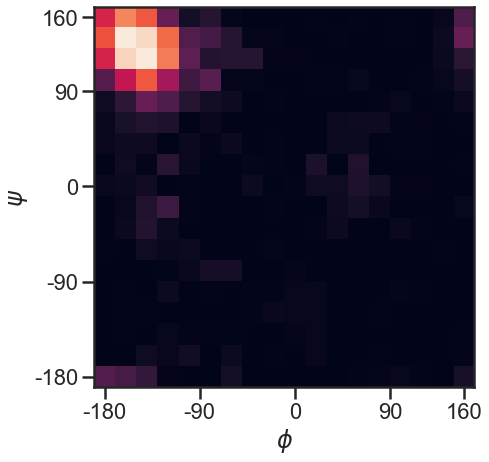

In [322]:
list_of_experiments = glob.glob(paths)
dic = tl.get_working_dic(list_of_experiments[0])

sns.set_context("poster")
sns.set_style("ticks")

list_of_predictions = []
list_of_weights = []

for path in list_of_experiments:
    dic = tl.get_working_dic(path) ## Reading TALOS prediction data
    list_of_predictions.append(dic) 
    list_of_weights.append(peak_box["Intensity"][int(run_id(path))]) ## Lookup number of TALOS run and find intensity of the corresponding point 
    
result = {}
i=0
for run in list_of_predictions:
    result[f'{num} {roi_type}'] = result.get(f'{num} {roi_type}', 0) + np.asarray(run[f'{num} {roi_type}'])*list_of_weights[i]
    i+=1

fig, axs = plt.subplots(1, 1, figsize=(7,7))

xticks = [0, 4.5, 9, 13.5, 17]
x_lbls = [-180, -90, 0, 90, 160]

yticks = [0, 3.5, 8, 12.5, 17]
y_lbls = [160, 90, 0, -90, -180]

distr = result[f'{num} {roi_type}']
distr = distr.reshape(18, 18)
distr = np.rot90(distr, 1)                     ##### !!! Peculiarities of Python
distr = distr/distr.max()
axs.imshow(distr, #cmap='YlGnBu_r', alpha = 1, 
           #interpolation='bilinear'
          )
plt.xticks(xticks, labels=x_lbls) # positions
plt.yticks(yticks, labels=y_lbls) # positions
plt.xlabel("$\phi$") 
plt.ylabel("$\psi$")
#plt.title(f'{num} {roi_type}', fontsize=14)
#axs.text(-.9, .5, res, va='center', ha='right', fontsize=15,
#        transform=axs[i,j].transAxes)

#fig.tight_layout()

np.save(f'{results_folder}/Distributions/{num}{roi_type}_distr_18x18.npy', distr)
fig.savefig(f'{results_folder}/Distributions/{num}{roi_type}_18x18.png', format='png', dpi=300)

plt.show()

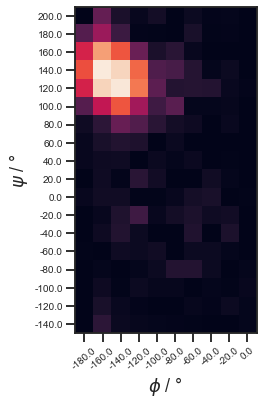

In [323]:
z = np.zeros((18, 1))
q = np.flip(np.flip(distr[:, 10:], axis=1), axis=0)

distr_folded_np = distr[:, :10]+np.concatenate((z, q, z), axis=1)

#distr_folded_np.shape

#plt.figure()
#plt.imshow(distr_1[:, :10])
#plt.figure()
sns.set_context("talk")
sns.set_style("ticks")

plt.figure(figsize=(6,6))
plt.imshow(np.roll(distr_folded_np, 2, axis=0))
plt.xticks(ticks=np.linspace(0,9,10), labels=np.linspace(-180, 0, 10), fontsize=10, rotation=40)
plt.yticks(ticks=np.linspace(0,17,18), labels=np.flip(np.linspace(-140, 200, 18), axis=0), fontsize=10)

plt.xlabel("$\phi$ / °") 
plt.ylabel("$\psi$ / °")

np.save(f'{results_folder}/Distributions/{num}{roi_type}_distr_folded_18x10.npy', np.roll(distr_folded_np, 2, axis=0))

plt.show()

# 3. Heterogeneity parameters

In [349]:
results_folder = "C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/Results natural" #Folder with 18x10 / 18x18 distributions or folders with TALOS predictions

Definition of Class `rama_map`

In [244]:
class rama_map(object):
    #gridpoint, plot=True, parameters=True
    
    import numpy as np
    import nmrglue as nmr
    np.set_printoptions(precision=3)
    import matplotlib.pyplot as plt
    import seaborn as sns

    from homemade import talos_vis as tl

    def read(self, gridpoint, num, folded=True):
        
        roi_type = assignments.loc[num]['Res'].unique()[0]
        res=f'{num} {roi_type}'
        if gridpoint is None:
            #distr = np.load(f"C:/Users/Krairy/sciebo/Hydrophobin TALOS analysis/Distributions/{num}{roi_type}_distr_18x18.npy")
            distr = np.load(f"{results_folder}/Distributions/{num}{roi_type}_distr_18x18.npy") ## Change if moving the notebook
        else:
            gridpoint=int(gridpoint)
            #dic_full = tl.get_working_dic(f'C:/Users/Krairy/sciebo/Hydrophobin TALOS analysis/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab')
            dic_full = tl.get_working_dic(f'{results_folder}/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab') ## Change if moving the notebook
            distr = np.asarray(dic_full[res])
            distr = np.rot90(distr.reshape(18,18), 1)
        
        if folded:
            z = np.zeros((18, 1))
            q = np.flip(np.flip(distr[:, 10:], axis=1), axis=0)
            distr_folded = distr[:, :10]+np.concatenate((z, q, z), axis=1)
            #### distr_folded = np.roll(distr_folded, 2,axis=0) ### no longer do!!
            return distr_folded / distr_folded.max()
        else:
            return distr / distr.max()
    
    def circ_var(self):
        
        from numpy import pi, sin, cos
        
        distr = self.distr
        
        X_phi = np.linspace(-pi, 0, 10)
        X_psi = np.flip(np.linspace(-pi, pi, 18))  
        
        ## Calculating marginal distributins
        Y_phi = distr.sum(axis=0) / distr.sum()
        Y_psi = distr.sum(axis=1) / distr.sum()
        
        V_phi = np.round( 1 - np.sqrt( (sin(X_phi) * Y_phi ).sum()  ** 2 
                        + (cos(X_phi) * Y_phi ).sum() ** 2 ), 3)
        V_psi = np.round( 1 - np.sqrt( (sin(X_psi) * Y_psi ).sum() ** 2 
                        + (cos(X_psi) * Y_psi ).sum() ** 2 ), 3)
        
        ### print(f'V_phi = {V_phi}\tV_psi = {V_psi}')
        return V_phi, V_psi 
    
    def R(self):    
        template = np.array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        
        distr = self.distr
        distr = distr/distr.sum() # PDF normalied by integral
        extended = np.where(template==1, distr, 0)
        helical = np.where(template==2, distr, 0)
        #if extended.max() > helical.max():
        if extended.sum() > helical.sum():
            return extended.sum()/helical.sum()
        else: 
            return helical.sum()/extended.sum()
    
#    def entropy(self, distr, axis):
#        stats.entropy(distr.sum(axis=axis))
    def flatness(self):
        distr = self.distr
        return distr.max() / distr.sum()
        
    def plot(self, title, save=False): 
        
        from matplotlib.patches import Ellipse
        sns.set_context("poster")
        sns.set_style("ticks")
        
        sigma_phi = self.sigma_phi
        sigma_psi = self.sigma_psi
        phi_mean = self.phi_mean
        psi_mean = self.psi_mean
        distr = self.distr
        
        plt.figure(figsize=(4,6))
        plt.imshow(distr/distr.max(), 
                   extent=(-190, 10, -150, 210), 
                   #cmap='YlGnBu_r', 
                   cmap='Greys_r', vmin=0, vmax=1, 
           #interpolation='bilinear'
                  )
        x_labels = np.linspace(-180, 0, 10)
        y_labels = np.flip(np.linspace(-140, 200, 18), axis=0)
        y_labels[0] = -160
        
        plt.xticks(ticks=np.linspace(-180, 0, 10), labels=x_labels, fontsize=10, rotation=40)
        plt.yticks(ticks=np.flip(np.linspace(-140, 200, 18)), labels=y_labels, fontsize=10)
        #plt.colorbar()
        ellipse = Ellipse((phi_mean, psi_mean), width=sigma_phi*2, height=sigma_psi*2, facecolor='none', edgecolor='y', linewidth=1.3)
        plt.scatter(phi_mean, psi_mean, c='y', s=40, marker='x')
        plt.title(title)
        ax = plt.gca()
        ax.set_xlabel("$\phi$ / °", fontsize=14) 
        ax.set_ylabel("$\psi$ / °", fontsize=14)
        ax.add_patch(ellipse)
        if save:
            plt.gcf().savefig(os.path.join(results_folder, f"{self.id}_{title}.png"), format="png", dpi=200)
        plt.show()
        
    def __init__(self, num, gridpoint, path, folded=True, verbose=True, title=None):
        
        ################ from matplotlib.patches import Ellipse # not working if imported here
        if gridpoint is None:
            self.id = 'sum'
        else:
            self.id = gridpoint
        if path is None:   
            self.path = f'C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/{num}{roi_type}/{num}{roi_type}_pred_{gridpoint}.tab/predABP.tab'
        else:
            self.path = path
        self.distr = self.read(gridpoint=gridpoint, num=num, folded=folded)
        distr = self.distr
        self.entr_phi = stats.entropy(distr.sum(axis=0))
        self.entr_psi = stats.entropy(distr.sum(axis=1))

In [350]:
residues = [25,26,28,30,34,40,41,42,43,46,53,54,55,57,63,64,66] # 53 left out for now
## residues = [25,26,28,30,34,40,41,42,46,57] # 55 left out for now

cols = np.arange(22,68)
het_params = pd.DataFrame(columns=cols, index=['V_phi', 'V_psi', 'flatness', 'R', 'S_phi', 'S_psi'])

for num in residues:
    roi_type = assignments.loc[num]['Res'].unique()[0]
    distr_folded = rama_map(num=num, gridpoint=None, path=None, folded=True)
    het_params.loc['V_phi', num] = distr_folded.circ_var()[0]
    het_params.loc['V_psi', num] = distr_folded.circ_var()[1]
    het_params.loc['flatness', num] = distr_folded.flatness()
    het_params.loc['R', num] = distr_folded.R()
    het_params.loc['sum', num] = distr_folded.distr.sum()
    het_params.loc['S_phi', num] = distr_folded.entr_phi
    het_params.loc['S_psi', num] = distr_folded.entr_psi

Figure saved as C:/Users/Admin/sciebo/Hydrophobin TALOS analysis/Results natural/Results_w_G.png


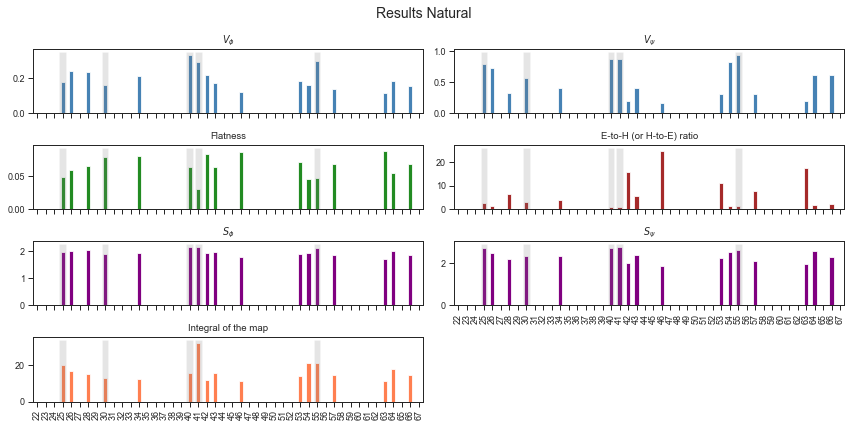

In [352]:
sns.set_context("paper")
sns.set_style("ticks")

#het_params[55]=None

indiv_plot_size = 6
nrows = 4
ncols = 2

#het_params.loc['StErrMean'] = (het_params.loc['StErrMean_phi']**2 + het_params.loc['StErrMean_psi']**2)**0.5
big_plot = het_params.transpose()[['V_phi', 'V_psi', 'flatness', 'R', 'S_phi', 'S_psi', 'sum']].plot(kind='bar', 
                        title=["$V_{\phi}$", "$V_{\psi}$", 'Flatness', 'E-to-H (or H-to-E) ratio',
                               '$S_{\phi}$', '$S_{\psi}$', 'Integral of the map', 
                               ], 
                        color=['steelblue', 'steelblue', 'forestgreen', 'brown', 
                              'purple', 'purple', 'coral'],
                        subplots=True, sharex=True, layout=(nrows, ncols), fontsize=9, figsize=(indiv_plot_size*ncols,indiv_plot_size/4*nrows), legend=False)

for row in big_plot:
    for a in row:
        height = a.get_ylim()[1]
        a.bar(x=np.asarray([25, 30, 40, 41, 55])-22, height=a.get_ylim()[1],
        #a.bar(x=np.arange(22,68), height=height, 
        color='gray', alpha=0.2)
    
plt.gcf().suptitle('Results Natural', fontsize=14)
plt.gcf().tight_layout()
plt.gcf().savefig(f'{results_folder}/Results_w_G.png', format='png', dpi=300)
print(f"Figure saved as {results_folder}/Results_w_G.png")
plt.show()

In [338]:
big_plot[1]

array([<AxesSubplot:title={'center':'Flatness'}>,
       <AxesSubplot:title={'center':'E-to-H (or H-to-E) ratio'}>],
      dtype=object)

### Score correction for average uncertainty

In [417]:
tl.get_working_dic(path).keys()

dict_keys(['10 C', '11 S', '12 I', '13 D', '14 D', '15 Y', '16 K', '17 P', '18 Y', '19 C', '20 C', '21 Q', '22 S', '23 M', '24 S', '25 G', '26 S', '27 A', '28 S', '29 L', '30 G', '31 C', '32 V', '33 V', '34 G', '35 V', '36 I', '37 G', '38 S', '39 Q', '40 C', '41 G', '42 A', '43 S', '44 V', '45 K', '46 C', '47 C', '48 K', '49 D', '50 D', '51 V', '52 T', '53 N', '54 T', '55 G', '56 N', '57 S', '58 F', '59 L', '60 I', '61 I', '62 N', '63 A', '64 A', '65 N', '66 C', '67 V'])

In [427]:
predictions = pd.DataFrame(index=pd.MultiIndex.from_product((residues, [0, 1, 2]), names=('ROI #', 'GridPoint #')), columns=['Distr', 'Intensity', 'Sigma_phi', 'Sigma_psi', 'Entr_phi', 'Entr_psi'])

In [333]:
residues = [25,26,30,34,40,41,42,43,46,53,55,57,63,64,66] # 28 left out for now

for num in residues:
    #num = 40
    roi_type = assignments.loc[num]['Res'].unique()[0]
    peak_box = pd.read_csv(os.path.join(absolute_path, f'PeakShapes/{num}{roi_type}.csv'), sep='\t', index_col=0)
    paths = os.path.join(absolute_path, f'{num}{roi_type}/*/predABP.tab')
    list_of_experiments = glob.glob(paths)
    
    index = [int(run_id(path)) for path in list_of_experiments]
    predictions = pd.DataFrame(##index=pd.MultiIndex.from_product((residues, np.arange(len(list_of_experiments))), names=('ROI #', 'GridPoint #'))
                             index=index, columns=['Distr', 'Intensity', 'Sigma_phi', 'Sigma_psi', 'Entr_phi', 'Entr_psi', 'flatness', 'R', 'phi_mean', 'psi_mean'])
    
        #dic = tl.get_working_dic(list_of_experiments[0])

    """for path in list_of_experiments:
        pred_id = int(run_id(path))
        run = rama_map(num=num, gridpoint=pred_id, path=path, verbose=False)
        predictions.loc[(num, pred_id), 'Distr'] = run.distr
        predictions.loc[(num, pred_id), 'Intensity'] = peak_box.loc[pred_id, "Intensity"] ## Lookup number of TALOS run and find intensity of the corresponding point 
        predictions.loc[(num, pred_id), 'Sigma_phi'] = run.sigma_phi
        predictions.loc[(num, pred_id), 'Sigma_psi'] = run.sigma_psi
        predictions.loc[(num, pred_id), 'Entr_phi'] = run.entr_phi
        predictions.loc[(num, pred_id), 'Entr_psi'] = run.entr_psi
    predictions"""

    for path in list_of_experiments:
        pred_id = int(run_id(path))
        run = rama_map(num=num, gridpoint=pred_id, path=path, verbose=False)
        predictions.loc[pred_id, 'Distr'] = run.distr
        predictions.loc[pred_id, 'Intensity'] = peak_box.loc[pred_id, "Intensity"] ## Lookup number of TALOS run and find intensity of the corresponding point 
        predictions.loc[pred_id, 'Sigma_phi'] = run.sigma_phi
        predictions.loc[pred_id, 'Sigma_psi'] = run.sigma_psi
        predictions.loc[pred_id, 'Entr_phi'] = run.entr_phi
        predictions.loc[pred_id, 'Entr_psi'] = run.entr_psi
        predictions.loc[pred_id, 'flatness'] = np.round(run.distr.max()/run.distr.sum(), 4)
        predictions.loc[pred_id, 'R'] = run.R()
        predictions.loc[pred_id, 'phi_mean'] = run.phi_mean
        predictions.loc[pred_id, 'psi_mean'] = run.psi_mean
        predictions['Weight'] = predictions['Intensity'] /  predictions['Intensity'].sum()
        
        """predictions.loc['Sigma_phi_corr'] = correction(predictions, 'Sigma_phi', 'Intensity') 
        predictions.loc['Sigma_psi_corr'] = correction(predictions, 'Sigma_psi', 'Intensity') 
        predictions.loc['Entr_phi_corr'] = correction(predictions, 'Entr_phi', 'Intensity') 
        predictions.loc['Entr_psi_corr'] = correction(predictions, 'Entr_psi', 'Intensity') """

    predictions.to_csv(os.path.join(absolute_path, f'Distributions/{num}{roi_type}.csv'), sep="\t")

### Plotting 2D convensional maps (folded)

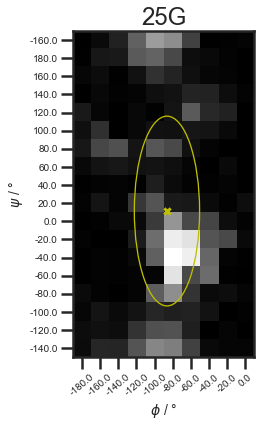

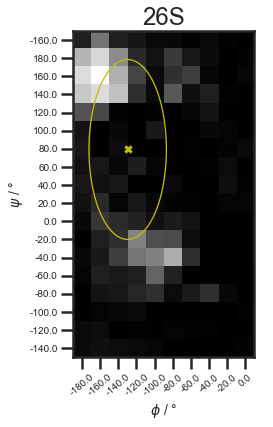

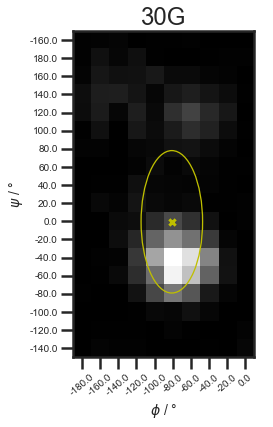

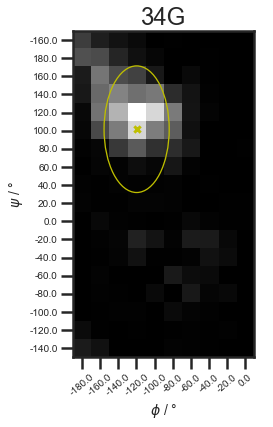

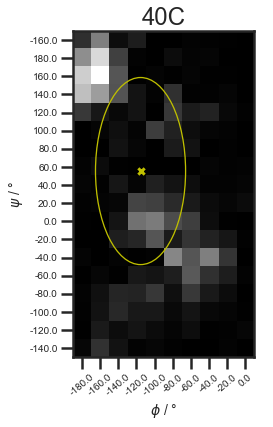

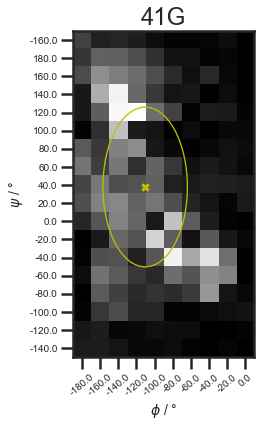

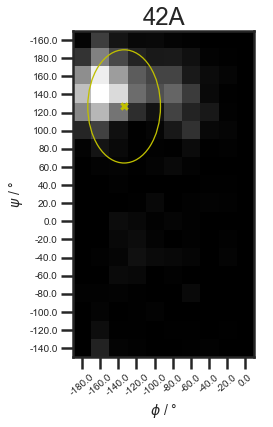

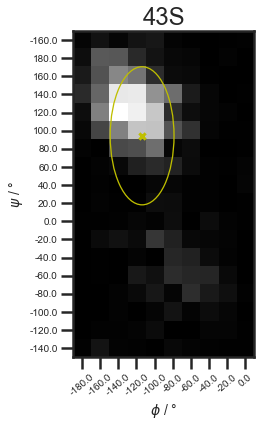

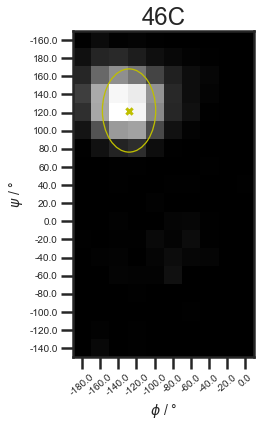

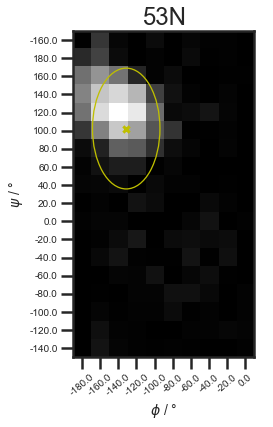

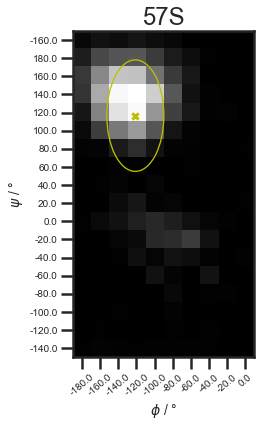

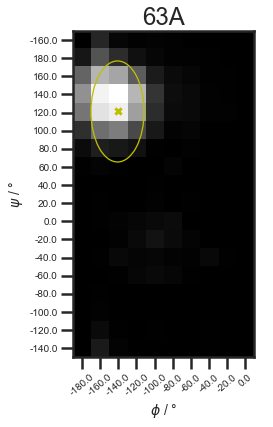

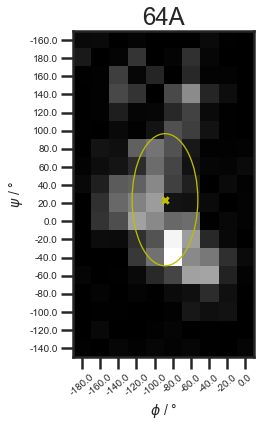

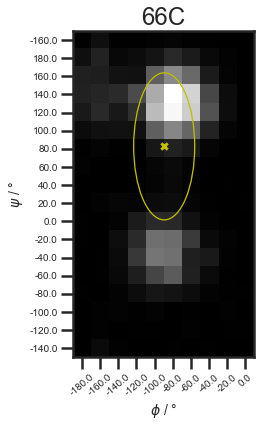

In [376]:
for num in residues:
    roi_type = assignments.loc[num]['Res'].unique()[0]
    #path = f'C:\\Users\\Admin\\sciebo\\Hydrophobin TALOS analysis\\Distributions\\{num}{roi_type}_distr_folded_18x10.npy'
    rama = rama_map(num=num, gridpoint=None, path=None, verbose=False)
    rama.plot(title=f"{num}{roi_type}", save=True)

### Polar plots

### Appendix

R is calculated as the ratio of the sums of these two areas:


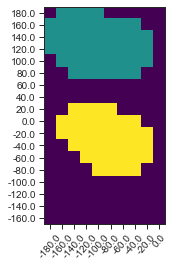

In [410]:
def parameters(distr, folded=True, verbose=True):
    
    # in degrees
    
    phi_s = np.linspace(-180, 0, 10)
    psi_s = np.flip(np.linspace(-140, 200, 18))  
    
    if not folded:
        phi_s = np.linspace(-180, 160, 18)                  

    distr_x = distr.ravel()
    phi_mean = np.sum(np.tile(phi_s, 18) * distr_x) / np.sum(distr_x)
    
    distr_y = distr.T.ravel()
    psi_mean = np.sum(np.tile(psi_s, 10) * distr_y) / np.sum(distr_y)
    
    c = center_of_mass(distr)
    phi_mean = (c[1]-9)*20
    psi_mean = -c[0]*20+200

    distr1 = distr.ravel()
    i = 0
    s = 0 
    for phi in phi_s:
        for psi in psi_s:
            s += ((phi - phi_mean)**2 + (psi - psi_mean)**2 ) * distr1[i] 
            i += 1
    
    distr1 = distr.ravel()
    s_phi = 0
    i=0
    for phi in np.tile(phi_s, 18):
        s_phi += ((phi - phi_mean)**2 * distr1[i]) 
        i+=1
    
    distr1 = distr.T.ravel()
    s_psi = 0
    i=0
    for psi in np.tile(psi_s, 10):
        s_psi += ((psi - psi_mean)**2 * distr1[i]) 
        #print(psi, '\t', psi - psi_mean, '\t', distr1[i], '\t', s_psi)
        #print(s_psi)
        #print()
        i+=1    
            
    sigma = np.sqrt(s / distr1.sum())
    sigma_phi = np.sqrt(s_phi / distr1.sum()) #??
    sigma_psi = np.sqrt(s_psi / distr1.sum()) #??
    
    # flatness
    flatness = np.max(distr)/np.sum(distr)
    
    ## everything is in degrees!
    if verbose:
        print(f'sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness\n{sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness}')
    return sigma, sigma_phi, sigma_psi, phi_mean, psi_mean, flatness

#def sigma_phi()

template = np.array([[0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                   [0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 2, 2, 2, 2, 0, 0, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 0, 0],
                   [0, 2, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 2, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 2, 2, 2, 2, 2, 2, 0],
                   [0, 0, 0, 0, 2, 2, 2, 2, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

def R(distr, template=template):    
    distr = distr/distr.sum() # PDF normalied by integral
    extended = np.where(template==1, distr, 0)
    helical = np.where(template==2, distr, 0)
    if extended.max() > helical.max():
        return extended.sum()/helical.sum()
    else: 
        return helical.sum()/extended.sum()
    
plt.imshow(template, cmap='viridis', extent=(-190, 10, -170, 190))
plt.xticks(np.linspace(-180, 0, 10), labels=np.linspace(-180, 0, 10), fontsize=10, rotation=49)
plt.yticks(np.linspace(-160, 180, 18), labels=np.linspace(-160, 180, 18), fontsize=10)
print('R is calculated as the ratio of the sums of these two areas:')
plt.show()